## esegui all'inizio

In [226]:
import h5py
import os
import numpy as np
import numpy as np
from tensorflow.keras.models import load_model

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
import numpy as np
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import Lasso
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from scipy.stats import ttest_ind

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc

import h5py
import os
import numpy as np
import numpy as np
from tensorflow.keras.models import load_model

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
import numpy as np
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier


from sklearn.linear_model import Lasso
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
#import pymrmr
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc

import os

In [304]:
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam

def encoder(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = GlobalAveragePooling2D()(x)  # Global Average Pooling
    x = Flatten()(x)
    encoded = Dense(32, activation='relu', kernel_regularizer=l1(10e-8))(x)
    encoder_model = Model(inputs, encoded, name='encoder')
    return encoder_model


# Ricrea l'architettura del modello encoder
input_shape = (64, 64, 1)
encoder = encoder(input_shape)

# Carica i pesi salvati
encoder.load_weights('/Users/alessiamenozzi/Desktop/encoder32.weights.h5')

In [321]:

# Percorso del file HDF5 da cui caricare i dati
load_path = "/Users/alessiamenozzi/Desktop/ThesisPlaques/pazienti_con_aree/classificator_data_bw_05.h5"
#load_path = "C:\\Users\\bsbar\\Desktop\\Tesi\\ThesisPlaques\\classificator_data.h5"

# Inizializza le liste per contenere i dati
loaded_class_images = []
loaded_class_labels = None
loaded_patients = None

# Apre il file HDF5 in modalità lettura
with h5py.File(load_path, 'r') as hf:
    # Itera su tutti i gruppi nel file HDF5
    for group_name in hf.keys():
        # Controlla se il nome del gruppo inizia con "patient_"
        if group_name.startswith("patient_"):
            group = hf[group_name]
            # Carica le immagini dal dataset 'images' all'interno del gruppo
            loaded_class_images.append(np.array(group['images']))
        elif group_name == "labels":
            # Carica le etichette dal dataset 'labels'
            loaded_class_labels = hf['labels'][:]
        elif group_name == "patients":
            # Carica i numeri dei pazienti dal dataset 'patients' e decodifica i byte in stringhe
            patients_array_bytes = hf['patients'][:]
            loaded_patients = [s.decode('utf-8') for s in patients_array_bytes]

print(f"Dati caricati da {load_path}")
print(f"Numero di pazienti: {len(loaded_class_images)}")
print(f"Esempio di immagini per paziente: {loaded_class_images[0].shape}")


# Carica il file CSV
file_path = "/Users/alessiamenozzi/Desktop/ThesisPlaques/data_rad_clin_DEF.csv"
#file_path = "C:\\Users\\bsbar\\Desktop\\Tesi\\ThesisPlaques\\data_rad_clin_DEF.csv"
data = pd.read_csv(file_path)

# Lista degli ID da escludere
ids_to_exclude = ["patient_TC_19", "patient_TC_40", "patient_TC_88", "patient_TC_150", "patient_TC_193"]

# Filtra il DataFrame per escludere le righe con gli ID specificati
filtered_data = data[~data['IDs_new'].isin(ids_to_exclude)]

# Estrae i valori dalla colonna 'label' del DataFrame filtrato
labels_column = filtered_data['label']

# Converte i valori della colonna 'label' in numeri interi
labels = labels_column.astype(int).tolist()

labels=np.array(labels)
print("Labels:", labels)
print("Number of labels:", len(labels))


# Carica il modello encoder
#encoder = load_model("/Users/alessiamenozzi/Desktop/ThesisPlaques/encoder_models/encoder_model32.h5", compile=False)
#encoder = load_model("/Users/alessiamenozzi/Desktop/encoder64_senzaDense.h5", compile=False)
#encoder = load_model("C:\\Users\\bsbar\\Desktop\\Tesi\\ThesisPlaques\\encoder_models\\encoder_model32.h5", compile=False)

# Funzione per ottenere le feature da una singola immagine
def get_features_from_image(image):
    image = image.astype('float32')
    image = image / 255.0
    # Ottieni le feature dall'encoder
    if len(image.shape) == 2:  # Se l'immagine è 64x64
        image = np.expand_dims(image, axis=-1)  # Aggiungi canale se necessario (per immagini in bianco e nero)
    image = np.expand_dims(image, axis=0)  # Aggiungi dimensione batch
    features = encoder.predict(image, verbose=False)
    features = np.squeeze(features)
    #print(features.shape)
    return np.array(features)

# Lista per salvare le feature delle immagini
patients = []

# Ottieni le feature per ogni immagine nella lista
for i in range(len(loaded_class_images)):
    features_list = []
    for img in loaded_class_images[i]:
        features = get_features_from_image(img)
        features_list.append(features)
    fetures_list = np.array(features_list)
    patients.append(features_list)

Dati caricati da /Users/alessiamenozzi/Desktop/ThesisPlaques/pazienti_con_aree/classificator_data_bw_05.h5
Numero di pazienti: 124
Esempio di immagini per paziente: (25, 64, 64)


Labels: [0 1 1 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 0
 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0 0 1 0
 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 1 1 0
 0 0 0 0 0 0 0 1 1 0 1 0 1]
Number of labels: 124


## funzioni 1

In [229]:
## FILE DI FUNZIONI

def continue_array(filtered_patients, labels):
    all_features = []
    for patient in filtered_patients:
        for image_features in patient:
            all_features.append(image_features)

    all_features_array = np.array(all_features)

    # Print the shape of the combined features array
    #print(f"Shape of combined features array: {all_features_array.shape}")

    # Initialize the new expanded labels and patient IDs vectors
    expanded_labels = []
    expanded_patient_ids = []

    # Assuming labels and loaded_patients are already defined
    # labels: A list of length 124 with labels for each patient
    # loaded_patients: A list of length 124 with IDs for each patient

    # Iterate over the filtered patients and expand the labels and patient IDs
    for i in range(len(filtered_patients)):
        num_images = len(filtered_patients[i])  # Number of images for the current patient
        expanded_labels.extend([labels[i]] * num_images)  # Assign the same label to all images of the patient
        expanded_patient_ids.extend([loaded_patients[i]] * num_images)  # Assign the same patient ID to all images of the patient

    # Convert the lists to NumPy arrays
    expanded_labels_array = np.array(expanded_labels)
    expanded_patient_ids_array = np.array(expanded_patient_ids)

    # Print the shapes of the new arrays to verify
    #print(f"Shape of expanded labels array: {expanded_labels_array.shape}")
    #print(f"Shape of expanded patient IDs array: {expanded_patient_ids_array.shape}")
    return all_features_array, expanded_labels_array, expanded_patient_ids_array


def filter_highly_correlated_features(df, corr, threshold=0.85):
    columns = np.full((corr.shape[0],), True, dtype=bool)
    removed_features = []

    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if corr.iloc[i, j] >= threshold:
                if columns[j]:
                    columns[j] = False
                    removed_features.append(df.columns[j])

    #selected_columns = df.columns[columns]
    return removed_features



def remove_features_from_patients(patients, features_to_remove):
    # Estrai gli indici delle caratteristiche da rimuovere
    feature_indices_to_remove = [int(feature.split('_')[1]) for feature in features_to_remove]
    
    # Rimuovi le caratteristiche corrispondenti dagli array dei pazienti
    final_patients = []
    for patient in patients:
        new_patients = []
        for image_features in patient:
            new_patient = np.delete(image_features, feature_indices_to_remove, axis=0)
            new_patients.append(new_patient)
        final_patients.append(np.array(new_patients))    

    return final_patients


def keep_features_in_patients(patients, features_to_keep):
    # Converti le stringhe degli indici in interi
    feature_indices_to_keep = [int(feature) for feature in features_to_keep]

    final_patients = []
    for patient in patients:
        new_patients = []
        for image_features in patient:
            # Seleziona solo le caratteristiche specificate negli array dei pazienti
            new_patient = np.take(image_features, feature_indices_to_keep, axis=0)
            new_patients.append(new_patient)
        final_patients.append(np.array(new_patients))

    return final_patients



def perform_correlation(z_train, y_train, numero = 32, threshold = 0.85):
    # Supponiamo che loaded_patients contenga le etichette dei pazienti

    all_images, _, _= continue_array(z_train, y_train)

    # Creazione del DataFrame con le immagini come righe e le features come colonne
    df = pd.DataFrame(all_images, columns=[f'feature_{i}' for i in range(numero)])

    # Visualizzazione del DataFrame
    corr_matrix = df.corr()

    # Se vuoi anche visualizzare la matrice di correlazione con Seaborn
    #plt.figure(figsize=(12, 10))
    #sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    #plt.title("Feature Correlation Matrix")
    #plt.show()  
    
    features_selected = filter_highly_correlated_features(df, corr_matrix, threshold)
    
    return features_selected



## FEATURE SELECTION LASSO
def select_features_with_lasso(X, y, alpha=0.001):
    
    # Fit Lasso regression model
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)

    # Get coefficients
    coefficients = lasso.coef_

    # Select features with non-zero coefficients
    selected_features = np.where(coefficients != 0)[0]

    # Create new feature matrix with only selected features
    X_selected = X[:, selected_features]

    return X_selected, selected_features

## FEATURE SELECTION LOGISTIC
def logistic_regression_feature_selection(X, y, num_features):
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X, y)
    coef_abs = np.abs(lr.coef_)
    feature_importances = np.mean(coef_abs, axis=0)
    selected_features = feature_importances.argsort()[-num_features:][::-1]
    # Create new feature matrix with only selected features
    X_selected = X[:, selected_features]
    return X_selected, selected_features


def mrmr_feature_selection(X, y, num_features):
    # Calcolare l'informazione mutua tra ogni caratteristica e il target
    mi = mutual_info_classif(X, y)
    
    # Standardizzare le caratteristiche
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Calcolare la distanza euclidea tra le caratteristiche
    distances = squareform(pdist(X_scaled.T, 'euclidean'))
    
    selected_features = []
    selected_indices = []
    
    # Selezionare la prima caratteristica con la massima informazione mutua
    first_feature_index = np.argmax(mi)
    selected_features.append(first_feature_index)
    selected_indices.append(first_feature_index)
    
    # Iterare per selezionare le caratteristiche rimanenti
    for _ in range(num_features - 1):
        max_relevance = -np.inf
        selected_feature_index = -1
        
        for i in range(X.shape[1]):
            if i in selected_indices:
                continue
            
            relevance = mi[i]
            redundancy = np.mean(distances[i, selected_indices])
            
            mrmr_score = relevance - redundancy
            
            if mrmr_score > max_relevance:
                max_relevance = mrmr_score
                selected_feature_index = i
        
        selected_features.append(selected_feature_index)
        selected_indices.append(selected_feature_index)

    X_selected = X[:, selected_indices]
    return X_selected, selected_indices

## FEATURE SELECTION MRMR
def mrmr_feature_selection1(X, y, num_features):
     
    feature_names = [f'feature_{i}' for i in range(X.shape[1])]
    data = pd.DataFrame(X, columns=feature_names)
    data['target'] = y
    data.columns = data.columns.astype(str)
    selected_features = pymrmr.mRMR(data, 'MIQ', num_features)
    selected_indices = [data.columns.get_loc(feature) for feature in selected_features]
    # Crea una nuova matrice delle caratteristiche con solo le caratteristiche selezionate
    X_selected = X[:, selected_indices]

    return X_selected, selected_indices


## FEATURE SELECTION RANDOM FOREST
def rf_feature_selection(X, y, num_features):
    # Inizializza il classificatore Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    # Addestra il modello
    rf.fit(X, y)
    # Ottieni l'importanza delle caratteristiche
    feature_importances = rf.feature_importances_
    # Seleziona gli indici delle caratteristiche più importanti
    selected_features = np.argsort(feature_importances)[-num_features:][::-1]
    # Crea una nuova matrice di caratteristiche con solo le caratteristiche selezionate
    X_selected = X[:, selected_features]
    return X_selected, selected_features


def p_value_feature_selection(X, num_features):
    """
    Seleziona le prime `num_features` caratteristiche dal vettore di caratteristiche.

    Args:
    X (np.ndarray): Matrice delle caratteristiche (numero di campioni, numero di caratteristiche).
    num_features (int): Numero di caratteristiche da selezionare.

    Returns:
    np.ndarray: Nuova matrice delle caratteristiche con solo le caratteristiche selezionate.
    np.ndarray: Indici delle caratteristiche selezionate.
    """
    # Controlla se num_features è maggiore del numero totale di caratteristiche
    if num_features > X.shape[1]:
        raise ValueError(f"num_features ({num_features}) è maggiore del numero totale di caratteristiche ({X.shape[1]})")

    # Seleziona i primi num_features indici
    selected_features = np.arange(num_features)
    
    # Crea una nuova matrice di caratteristiche con solo le caratteristiche selezionate
    X_selected = X[:, selected_features]
    
    return X_selected, selected_features

## FUNZIONE PER RIMUOVERE FEATURES SELEZIONATE
def filter_patients_features(filtered_patients, selected_features):
    """
    Removes the non-selected features from the filtered_patients array.

    Parameters:
    filtered_patients (list of numpy.ndarray): The list containing patients' images' features.
    selected_features (numpy.ndarray): The indices of the selected features.

    Returns:
    list of numpy.ndarray: The new filtered_patients array with only the selected features.
    """
    filtered_patients_selected = []

    for patient_features in filtered_patients:
        # Select only the features specified in selected_features
        patient_features_selected = patient_features[:, selected_features]
        filtered_patients_selected.append(patient_features_selected)

    return filtered_patients_selected


def select_features_by_p_value(x_train_expanded, y_train_expanded, p_value_threshold=0.1):

    p_values = []
    num_features = x_train_expanded.shape[1]

    for i in range(num_features):
        feature = x_train_expanded[:, i]
        group_0 = feature[y_train_expanded == 0]
        group_1 = feature[y_train_expanded == 1]
        t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)
        p_values.append(p_val)

    # Convertire i p-value in un array numpy per ordinare più facilmente
    p_values = np.array(p_values)

    # Selezionare le caratteristiche con p-value < soglia
    selected_features_indices = np.where(p_values < p_value_threshold)[0]

    # Ordinare le caratteristiche selezionate in base ai p-value
    sorted_indices = selected_features_indices[np.argsort(p_values[selected_features_indices])]

    x_train_expanded = x_train_expanded[:, sorted_indices]

    return x_train_expanded, sorted_indices



## funzioni 2 per la classificazione

### classificazione

In [230]:
from imblearn.over_sampling import ADASYN

def prob_to_binary(predictions_proba, patient_scores, threshold, mode):
        final_predictionarray=[]          
        if(mode=='MV'): ## majority voting
            for p in predictions_proba:
                test_patient_predictions=[]
                for proba in p:               
                    predictions_binary = 1 if proba[0][1] > threshold else 0
                    test_patient_predictions.append(predictions_binary)
                count_0 = np.sum(np.array(test_patient_predictions)==0) 
                count_1 = np.sum(np.array(test_patient_predictions)==1)                                   
                final_prediction = 0 if count_0 > count_1 else 1
                final_predictionarray.append(final_prediction)
        
        elif (mode=='Mean'): ## mean
            for score in patient_scores:
                predictions_binary = 1 if score > threshold else 0
                final_predictionarray.append(predictions_binary)    
    
        return final_predictionarray


def classification_method1(selector, alpha, classifier, x_train_expanded, y_train_expanded, patients_test, y_test, features_test, num_features, modePrediction, thresholds=np.arange(0.001, 0.501, 0.001), mode = "Val", selected_features= [0]):

    if(mode == "Val"):
            selected_features = None  # Inizializziamo selected_features per prevenire l'errore UnboundLocalError
            
            if num_features != len(x_train_expanded[0]) or alpha != 0:
                if selector == "lasso":
                    X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
                elif selector == "logistic": 
                    X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
                elif selector == "mrmr":
                    X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
                elif selector == "rf":
                    X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
                elif selector=="p_value":
                    X_selected, selected_features= p_value_feature_selection(x_train_expanded, num_features)
                else:
                    print("Wrong selector. Choose between: mrmr, rf, logistic, lasso")
                    return
                
                features_test = filter_patients_features(features_test, selected_features)
            else:
                X_selected = x_train_expanded
                selected_features = list(range(len(x_train_expanded[0])))  # Selezioniamo tutte le feature se non si fa feature selection
            number_features = len(selected_features)  # Ora number_features è sempre definito correttamente
        
            smote = SMOTE(random_state=42)
            #adasyn = ADASYN(random_state=42)

            # Applicare SMOTE al set di dati di addestramento espanso
            X_resampled, y_resampled = smote.fit_resample(X_selected, y_train_expanded)
            classifier.fit(X_resampled, y_resampled)
   
    if (mode == "Test"):
        features_test = filter_patients_features(features_test, selected_features)
        number_features = len(selected_features)

    ### questo trova le probabilità e fa la media
    temp_array = []
    patient_scores = []
    
    for x in range(len(patients_test)):
        patient_predictions = []
        patient_predictions1 = []
        r=len(features_test[x])
        for i in range(r):
        #for i in range(len(features_test[x][0])):
            dato = features_test[x][i].reshape(1, -1)
            prediction = classifier.predict_proba(dato)
            prediction1 = classifier.predict_proba(dato)[:,1]
            patient_predictions.append(prediction)
            patient_predictions1.append(prediction1)
            mean=np.mean(patient_predictions1)

        patient_scores.append(mean) ## contiene la media delle probabilità
        temp_array.append(patient_predictions) ## contiene tutte le probabilità
        
    best_f1_score = 0
    best_threshold = None
    best_precision=0
    best_recall=0
    best_prediction=[]
    
    # Valuta le performance utilizzando diverse threshold
    #thresholds = np.arange(0.001, 0.501, 0.001)
    #thresholds=[0.5]
    if isinstance(thresholds, (int, float, complex)):
        thresholds=[thresholds]

    ## se non viene specificato usi il parametro di default 
    if(len(thresholds)!=1):
        for threshold in thresholds:
            binary_predictions = prob_to_binary(temp_array, patient_scores, threshold, modePrediction)
            f1 = f1_score(y_test, binary_predictions)
            if f1 > best_f1_score:
                best_f1_score = f1
                best_threshold = threshold
                best_precision = precision_score(y_test, binary_predictions)
                best_recall = recall_score(y_test, binary_predictions)
                best_prediction=binary_predictions

    else: ## qui vuol dire che è il set di test che usa la threshold migliore
        best_threshold = thresholds
        best_prediction=prob_to_binary(temp_array, patient_scores, best_threshold, modePrediction)
        best_f1_score = f1_score(y_test, best_prediction)
        best_precision = precision_score(y_test, best_prediction)
        best_recall = recall_score(y_test, best_prediction)

    #print(f"La migliore threshold è {best_threshold} con f1score di {best_f1_score} e precision {best_precision} e recall {best_recall}.")
    y_test= np.array(y_test)
    best_prediction=np.array(best_prediction)
    test_accuracy = accuracy_score(y_test, best_prediction)


    #test_precision = precision_score(y_test, best_prediction)
    #test_recall = recall_score(y_test, best_prediction)
    
    precision, recall, _ = precision_recall_curve(y_test, patient_scores)
    pr_auc = average_precision_score(y_test, patient_scores)

    #fpr, tpr, _ = roc_curve(y_test, best_prediction)
    roc_auc= roc_auc_score(y_test, patient_scores)


    conf= confusion_matrix(y_test, best_prediction)
    return best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, best_threshold, number_features, selected_features, classifier



In [267]:
def classification_method2(classifier, x_train_expanded, y_train_expanded, patients_test, y_test, features_test, thresholds, mode):
       
    smote = SMOTE(random_state=42)
    #adasyn = ADASYN(random_state=42)


    X_resampled, y_resampled = smote.fit_resample(x_train_expanded, y_train_expanded)
    #X_resampled, y_resampled = adasyn.fit_resample(x_train_expanded, y_train_expanded)
    classifier.fit(X_resampled, y_resampled)


    temp_array = []
    patient_scores = []
    
    for x in range(len(patients_test)):
        patient_predictions = []
        patient_predictions1 = []
        r=len(features_test[x])
        for i in range(r):
        #for i in range(len(features_test[x][0])):
            dato = features_test[x][i].reshape(1, -1)
            prediction = classifier.predict_proba(dato)
            prediction1 = classifier.predict_proba(dato)[:,1]
            patient_predictions.append(prediction)
            patient_predictions1.append(prediction1)
            mean=np.mean(patient_predictions1)

        patient_scores.append(mean) ## contiene la media delle probabilità
        temp_array.append(patient_predictions) ## contiene tutte le probabilità


    best_f1_score = 0
    best_threshold = None
    best_precision=0
    best_recall=0
    best_prediction=[]
 
    if isinstance(thresholds, (int, float, complex)):
        thresholds=[thresholds]

    best_threshold = thresholds
    best_prediction=prob_to_binary(temp_array, patient_scores, best_threshold, mode)
    best_f1_score = f1_score(y_test, best_prediction)
    best_precision = precision_score(y_test, best_prediction)
    best_recall = recall_score(y_test, best_prediction)

    y_test= np.array(y_test)
    best_prediction=np.array(best_prediction)
    test_accuracy = accuracy_score(y_test, best_prediction)


    conf= confusion_matrix(y_test, best_prediction)
    return best_f1_score, best_precision, best_recall, conf, test_accuracy



### best threshold

In [232]:
def find_best_threshold_features(results_rf, selector):
    best_thresholds = []
    best_num_features=[]
    best_alpha=[]

    fold_results = results_rf[selector]
        
        # Inizialmente, tutti gli indici con il massimo F1 score
    best_f1_indices = np.where(fold_results['f1'] == np.max(fold_results['f1']))[0]
        
    if len(best_f1_indices) > 1:
            # In caso di parità di F1, considera il pr_auc
            max_pr_auc = max(fold_results['pr_auc'][j] for j in best_f1_indices)
            best_f1_indices = [j for j in best_f1_indices if fold_results['pr_auc'][j] == max_pr_auc]
            # In caso di ulteriore parità, considera l'accuracy
            if len(best_f1_indices)!=1:
                max_accuracy = max(fold_results['accuracy'][j] for j in best_f1_indices)
                best_f1_indices = [j for j in best_f1_indices if fold_results['accuracy'][j] == max_accuracy]
                if len(best_f1_indices)!=1:
                    max_roc_auc = max(fold_results['roc_auc'][j] for j in best_f1_indices)
                    best_f1_indices = [j for j in best_f1_indices if fold_results['roc_auc'][j] == max_roc_auc]
                    #best_f1_indices= best_f1_indices[0]
           
    best_index = best_f1_indices[0]


    # Ottieni l'indice finale del miglior F1 score
    best_threshold=fold_results['best_threshold'][best_index]

    if selector == 'lasso':
        mean_param=fold_results['alpha'][best_index]
    else:
        mean_param=fold_results['num_features'][best_index]



    return best_threshold, mean_param


## codice con split e cross val

In [322]:
#patients_train, patients_test, y_train, y_test, features_train, features_test= train_test_split(loaded_patients, labels, patients, test_size=0.2, shuffle=True, stratify=labels, random_state=46)

patients_train1, patients_test, y_train1, y_test, features_train1, features_test= train_test_split(loaded_patients, labels, patients, test_size=0.2, shuffle=False, random_state=1)
#patients_train, patients_val, y_train, y_val, features_train, features_val= train_test_split(patients_train1, y_train1, features_train1, test_size=0.3, shuffle=True, stratify=y_train1, random_state=1)
patients_train, patients_val, y_train, y_val, features_train, features_val= train_test_split(patients_train1, y_train1, features_train1, test_size=0.3, shuffle=False, random_state=1)

print(patients_train)
print(patients_test)
print(len(features_train))
print(len(features_train[0][0]))
print(len(features_train[1]))
print(len(features_train[2]))
print(len(patients_val))


['5', '12', '15', '16', '17', '22', '23', '24', '25', '26', '27', '29', '30', '31', '33', '35', '36', '38', '39', '41', '42', '43', '44', '46', '47', '48', '50', '52', '53', '54', '56', '57', '58', '59', '60', '61', '62', '64', '65', '68', '69', '70', '71', '74', '75', '76', '78', '79', '81', '82', '84', '85', '86', '87', '89', '90', '91', '92', '94', '95', '96', '98', '100', '101', '102', '103', '104', '105', '106']
['147', '149', '153', '155', '158', '159', '161', '163', '166', '168', '169', '170', '171', '175', '176', '178', '182', '183', '188', '189', '190', '197', '199', '200', '205']
69
32
17
43
30


In [323]:
alpha_values = np.linspace(0, 0.006, 30).tolist()

#selectors=['p_value']
#classifiers=['SVM']
selectors=['p_value', 'mrmr','rf', 'logistic', 'lasso']
classifiers=['RandomForest', 'Logistic', 'XgBoost', 'MLP', 'SVM']

## Features con p-value

## LOOP con tutti i selector e classificatori

In [324]:

results_test_MV=[{} for _ in range(len(classifiers))]
results_val_MV = [{} for _ in range(len(classifiers))]
starting_features = len(features_train[0][0])
i=0
for classifier in classifiers:
    print("Starting with classifier:", classifier)
    for selector in selectors: 
        print("Doing with selector:", selector)
        results_test_MV[i][selector] = {
                'classifier': classifier,
                'alpha': [],
                'num_features': [],
                'pr_auc': [],
                'best_precision' :[],
                'best_recall':[],
                'roc_auc':[],
                'f1':[],
                'accuracy':[],
                'confusion_matrix':[],
                'best_threshold':[],
                'selected_features': []
                }
        results_val_MV[i][selector] = {
                'classifier': classifier,
                'alpha': [],
                'num_features': [],
                'pr_auc': [],
                'best_precision' :[],
                'best_recall':[],
                'roc_auc':[],
                'f1':[],
                'accuracy':[],
                'confusion_matrix':[],
                'best_threshold':[],
                'selected_features': []
                }


        features=perform_correlation(features_train, y_train, starting_features, 0.85)

        final_patients_train=remove_features_from_patients(features_train, features)
        final_patients_test=remove_features_from_patients(features_test, features)
        final_patients_val=remove_features_from_patients(features_val, features)

        x_train_expanded, y_train_expanded, _ = continue_array(final_patients_train, y_train)

        x_train_expanded, sf= select_features_by_p_value(x_train_expanded, y_train_expanded)
        
        final_patients_test=keep_features_in_patients(final_patients_test, sf)
        final_patients_val=keep_features_in_patients(final_patients_val, sf)
        print(len(sf))
        print("len(final_patients_test)", len(final_patients_test[0][0]))
        print("len(final_patients_val)", len(final_patients_val[0][0]))
        print("len(x_train_expanded)", len(x_train_expanded[0]))

        if selector == 'lasso':
                for alpha in alpha_values:
                        print("sto facendo alpha:",alpha)

                        if(classifier=='RandomForest'):
                             classi = RandomForestClassifier(n_estimators=100, random_state=42)
                        if(classifier=='Logistic'):
                             classi = LogisticRegression()
                        if(classifier=='SVM'):
                             classi = SVC(kernel='rbf', probability=True, random_state=42)
                        if(classifier=='XgBoost'):
                             classi = XGBClassifier()
                        if(classifier=='MLP'):
                             classi = MLPClassifier(hidden_layer_sizes=(128,64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
                        
                        best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt, number_features, selected_features, classifier= classification_method1(
                            selector, alpha, classi, x_train_expanded, y_train_expanded, 
                            patients_val, y_val, final_patients_val, 0, 'MV'
                        )

                        if(best_f1_score==0 and best_precision==0 and best_recall==0):
                            break
                    
                        results_val_MV[i][selector]['alpha'].append(alpha)
                        results_val_MV[i][selector]['selected_features'].append(selected_features)
                        results_val_MV[i][selector]['num_features'].append(number_features)
                        results_val_MV[i][selector]['pr_auc'].append(pr_auc)
                        results_val_MV[i][selector]['best_precision'].append(best_precision)
                        results_val_MV[i][selector]['best_recall'].append(best_recall)
                        results_val_MV[i][selector]['roc_auc'].append(roc_auc)
                        results_val_MV[i][selector]['f1'].append(best_f1_score)
                        results_val_MV[i][selector]['accuracy'].append(test_accuracy)
                        results_val_MV[i][selector]['confusion_matrix'].append(conf)
                        results_val_MV[i][selector]['best_threshold'].append(bt)

                        ## classifico il test

                        best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt, number_features, selected_features, _= classification_method1(
                                    selector, alpha, classifier, x_train_expanded, y_train_expanded, 
                                    patients_test, y_test, final_patients_test, 0, 'MV',  bt, "Test", selected_features)
                        
                        
                        results_test_MV[i][selector]['alpha'].append(alpha)
                        results_test_MV[i][selector]['num_features'].append(number_features)
                        results_test_MV[i][selector]['selected_features'].append(selected_features)
                        results_test_MV[i][selector]['pr_auc'].append(pr_auc)
                        results_test_MV[i][selector]['best_precision'].append(best_precision)
                        results_test_MV[i][selector]['best_recall'].append(best_recall)
                        results_test_MV[i][selector]['roc_auc'].append(roc_auc)
                        results_test_MV[i][selector]['f1'].append(best_f1_score)
                        results_test_MV[i][selector]['accuracy'].append(test_accuracy)
                        results_test_MV[i][selector]['confusion_matrix'].append(conf)
                        results_test_MV[i][selector]['best_threshold'].append(bt)
                        
                        
                        # Plot dei risultati per 'lasso'

        else:
                    for t in range(2, len(x_train_expanded[0])+1):
                         
                         print("sto facendo features:",t)
                         
                         if(classifier=='RandomForest'):
                             classi = RandomForestClassifier(n_estimators=100, random_state=42)
                         if(classifier=='Logistic'):
                             classi = LogisticRegression()
                         if(classifier=='SVM'):
                             classi = SVC(kernel='rbf', probability=True, random_state=42)
                         if(classifier=='XgBoost'):
                             classi = XGBClassifier()
                         if(classifier=='MLP'):
                             classi = MLPClassifier(hidden_layer_sizes=(128,64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
                         
                         best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt, _, selected_features, classifier= classification_method1(
                            selector, 0, classi, x_train_expanded, y_train_expanded, 
                            patients_val, y_val, final_patients_val, t, 'MV'
                        )
                         results_val_MV[i][selector]['num_features'].append(t)
                         results_val_MV[i][selector]['pr_auc'].append(pr_auc)
                         results_val_MV[i][selector]['selected_features'].append(selected_features)
                         results_val_MV[i][selector]['best_precision'].append(best_precision)
                         results_val_MV[i][selector]['best_recall'].append(best_recall)
                         results_val_MV[i][selector]['roc_auc'].append(roc_auc)
                         results_val_MV[i][selector]['f1'].append(best_f1_score)
                         results_val_MV[i][selector]['accuracy'].append(test_accuracy)
                         results_val_MV[i][selector]['confusion_matrix'].append(conf)
                         results_val_MV[i][selector]['best_threshold'].append(bt)

                         ## classifico test
                         best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt, number_features, selected_features, _= classification_method1(
                                        selector, 0, classifier, x_train_expanded, y_train_expanded, 
                                        patients_test, y_test, final_patients_test, t, 'MV', bt, "Test", selected_features)
                         
                         results_test_MV[i][selector]['num_features'].append(t)
                         results_test_MV[i][selector]['selected_features'].append(selected_features)
                         results_test_MV[i][selector]['pr_auc'].append(pr_auc)
                         results_test_MV[i][selector]['best_precision'].append(best_precision)
                         results_test_MV[i][selector]['best_recall'].append(best_recall)
                         results_test_MV[i][selector]['roc_auc'].append(roc_auc)
                         results_test_MV[i][selector]['f1'].append(best_f1_score)
                         results_test_MV[i][selector]['accuracy'].append(test_accuracy)
                         results_test_MV[i][selector]['confusion_matrix'].append(conf)
                         results_test_MV[i][selector]['best_threshold'].append(bt)


        #mean_threshold, mean_param  = find_best_threshold_features(results_val[i], selector)
        #print(f"The mean best threshold for {selector} is: {mean_threshold}")
    
        
    i=i+1


 
        #plot_results(results_rf, results_test_rf, selector)

            

Starting with classifier: RandomForest
Doing with selector: p_value
20
len(final_patients_test) 20
len(final_patients_val) 20
len(x_train_expanded) 20
sto facendo features: 2
sto facendo features: 3
sto facendo features: 4
sto facendo features: 5
sto facendo features: 6
sto facendo features: 7
sto facendo features: 8
sto facendo features: 9
sto facendo features: 10
sto facendo features: 11
sto facendo features: 12
sto facendo features: 13
sto facendo features: 14
sto facendo features: 15
sto facendo features: 16
sto facendo features: 17
sto facendo features: 18
sto facendo features: 19
sto facendo features: 20
Doing with selector: mrmr
20
len(final_patients_test) 20
len(final_patients_val) 20
len(x_train_expanded) 20
sto facendo features: 2
sto facendo features: 3
sto facendo features: 4
sto facendo features: 5
sto facendo features: 6
sto facendo features: 7
sto facendo features: 8
sto facendo features: 9
sto facendo features: 10
sto facendo features: 11
sto facendo features: 12
sto fa

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.834e+02, tolerance: 4.177e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

sto facendo alpha: 0.00020689655172413793
sto facendo alpha: 0.00041379310344827585
sto facendo alpha: 0.0006206896551724137
sto facendo alpha: 0.0008275862068965517
sto facendo alpha: 0.0010344827586206897
sto facendo alpha: 0.0012413793103448274
sto facendo alpha: 0.0014482758620689654
sto facendo alpha: 0.0016551724137931034
sto facendo alpha: 0.0018620689655172414
sto facendo alpha: 0.0020689655172413794
sto facendo alpha: 0.0022758620689655173
sto facendo alpha: 0.002482758620689655
sto facendo alpha: 0.002689655172413793
sto facendo alpha: 0.002896551724137931
sto facendo alpha: 0.003103448275862069
sto facendo alpha: 0.003310344827586207
sto facendo alpha: 0.003517241379310345
sto facendo alpha: 0.0037241379310344828
sto facendo alpha: 0.00393103448275862
sto facendo alpha: 0.004137931034482759
sto facendo alpha: 0.004344827586206896
sto facendo alpha: 0.004551724137931035
sto facendo alpha: 0.004758620689655172
sto facendo alpha: 0.00496551724137931
sto facendo alpha: 0.0051724

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.834e+02, tolerance: 4.177e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

sto facendo alpha: 0.00020689655172413793
sto facendo alpha: 0.00041379310344827585
sto facendo alpha: 0.0006206896551724137
sto facendo alpha: 0.0008275862068965517
sto facendo alpha: 0.0010344827586206897
sto facendo alpha: 0.0012413793103448274
sto facendo alpha: 0.0014482758620689654
sto facendo alpha: 0.0016551724137931034
sto facendo alpha: 0.0018620689655172414
sto facendo alpha: 0.0020689655172413794
sto facendo alpha: 0.0022758620689655173
sto facendo alpha: 0.002482758620689655
sto facendo alpha: 0.002689655172413793
sto facendo alpha: 0.002896551724137931
sto facendo alpha: 0.003103448275862069
sto facendo alpha: 0.003310344827586207
sto facendo alpha: 0.003517241379310345
sto facendo alpha: 0.0037241379310344828
sto facendo alpha: 0.00393103448275862
sto facendo alpha: 0.004137931034482759
sto facendo alpha: 0.004344827586206896
sto facendo alpha: 0.004551724137931035
sto facendo alpha: 0.004758620689655172
sto facendo alpha: 0.00496551724137931
sto facendo alpha: 0.0051724

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.834e+02, tolerance: 4.177e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

sto facendo alpha: 0.00020689655172413793
sto facendo alpha: 0.00041379310344827585
sto facendo alpha: 0.0006206896551724137
sto facendo alpha: 0.0008275862068965517
sto facendo alpha: 0.0010344827586206897
sto facendo alpha: 0.0012413793103448274
sto facendo alpha: 0.0014482758620689654
sto facendo alpha: 0.0016551724137931034
sto facendo alpha: 0.0018620689655172414
sto facendo alpha: 0.0020689655172413794
sto facendo alpha: 0.0022758620689655173
sto facendo alpha: 0.002482758620689655
sto facendo alpha: 0.002689655172413793
sto facendo alpha: 0.002896551724137931
sto facendo alpha: 0.003103448275862069
sto facendo alpha: 0.003310344827586207
sto facendo alpha: 0.003517241379310345
sto facendo alpha: 0.0037241379310344828
sto facendo alpha: 0.00393103448275862
sto facendo alpha: 0.004137931034482759
sto facendo alpha: 0.004344827586206896
sto facendo alpha: 0.004551724137931035
sto facendo alpha: 0.004758620689655172
sto facendo alpha: 0.00496551724137931
sto facendo alpha: 0.0051724

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.834e+02, tolerance: 4.177e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

sto facendo alpha: 0.00020689655172413793
sto facendo alpha: 0.00041379310344827585
sto facendo alpha: 0.0006206896551724137
sto facendo alpha: 0.0008275862068965517
sto facendo alpha: 0.0010344827586206897
sto facendo alpha: 0.0012413793103448274
sto facendo alpha: 0.0014482758620689654
sto facendo alpha: 0.0016551724137931034
sto facendo alpha: 0.0018620689655172414
sto facendo alpha: 0.0020689655172413794
sto facendo alpha: 0.0022758620689655173
sto facendo alpha: 0.002482758620689655
sto facendo alpha: 0.002689655172413793
sto facendo alpha: 0.002896551724137931
sto facendo alpha: 0.003103448275862069
sto facendo alpha: 0.003310344827586207
sto facendo alpha: 0.003517241379310345
sto facendo alpha: 0.0037241379310344828
sto facendo alpha: 0.00393103448275862
sto facendo alpha: 0.004137931034482759
sto facendo alpha: 0.004344827586206896
sto facendo alpha: 0.004551724137931035
sto facendo alpha: 0.004758620689655172
sto facendo alpha: 0.00496551724137931
sto facendo alpha: 0.0051724

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.834e+02, tolerance: 4.177e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

sto facendo alpha: 0.00020689655172413793
sto facendo alpha: 0.00041379310344827585
sto facendo alpha: 0.0006206896551724137
sto facendo alpha: 0.0008275862068965517
sto facendo alpha: 0.0010344827586206897
sto facendo alpha: 0.0012413793103448274
sto facendo alpha: 0.0014482758620689654
sto facendo alpha: 0.0016551724137931034
sto facendo alpha: 0.0018620689655172414
sto facendo alpha: 0.0020689655172413794
sto facendo alpha: 0.0022758620689655173
sto facendo alpha: 0.002482758620689655
sto facendo alpha: 0.002689655172413793
sto facendo alpha: 0.002896551724137931
sto facendo alpha: 0.003103448275862069
sto facendo alpha: 0.003310344827586207
sto facendo alpha: 0.003517241379310345
sto facendo alpha: 0.0037241379310344828
sto facendo alpha: 0.00393103448275862
sto facendo alpha: 0.004137931034482759
sto facendo alpha: 0.004344827586206896
sto facendo alpha: 0.004551724137931035
sto facendo alpha: 0.004758620689655172
sto facendo alpha: 0.00496551724137931
sto facendo alpha: 0.0051724

In [325]:

results_test_Mean=[{} for _ in range(len(classifiers))]
results_val_Mean = [{} for _ in range(len(classifiers))]
starting_features = len(features_train[0][0])
i=0
for classifier in classifiers:
    print("Starting with classifier:", classifier)
    for selector in selectors: 
        print("Doing with selector:", selector)
        results_test_Mean[i][selector] = {
                'classifier': classifier,
                'alpha': [],
                'num_features': [],
                'pr_auc': [],
                'best_precision' :[],
                'best_recall':[],
                'roc_auc':[],
                'f1':[],
                'accuracy':[],
                'confusion_matrix':[],
                'best_threshold':[],
                'selected_features': []
                }
        results_val_Mean[i][selector] = {
                'classifier': classifier,
                'alpha': [],
                'num_features': [],
                'pr_auc': [],
                'best_precision' :[],
                'best_recall':[],
                'roc_auc':[],
                'f1':[],
                'accuracy':[],
                'confusion_matrix':[],
                'best_threshold':[],
                'selected_features': []
                }


        features=perform_correlation(features_train, y_train, starting_features, 0.85)

        final_patients_train=remove_features_from_patients(features_train, features)
        final_patients_test=remove_features_from_patients(features_test, features)
        final_patients_val=remove_features_from_patients(features_val, features)

        x_train_expanded, y_train_expanded, _ = continue_array(final_patients_train, y_train)

        x_train_expanded, sf= select_features_by_p_value(x_train_expanded, y_train_expanded)
        
        final_patients_test=keep_features_in_patients(final_patients_test, sf)
        final_patients_val=keep_features_in_patients(final_patients_val, sf)
        print(len(sf))
        print("len(final_patients_test)", len(final_patients_test[0][0]))
        print("len(final_patients_val)", len(final_patients_val[0][0]))
        print("len(x_train_expanded)", len(x_train_expanded[0]))

        if selector == 'lasso':
                for alpha in alpha_values:
                        print("sto facendo alpha:",alpha)

                        if(classifier=='RandomForest'):
                             classi = RandomForestClassifier(n_estimators=100, random_state=42)
                        if(classifier=='Logistic'):
                             classi = LogisticRegression()
                        if(classifier=='SVM'):
                             classi = SVC(kernel='rbf', probability=True, random_state=42)
                        if(classifier=='XgBoost'):
                             classi = XGBClassifier()
                        if(classifier=='MLP'):
                             classi = MLPClassifier(hidden_layer_sizes=(128,64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
                        
                        best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt, number_features, selected_features, classifier= classification_method1(
                            selector, alpha, classi, x_train_expanded, y_train_expanded, 
                            patients_val, y_val, final_patients_val, 0, 'Mean'
                        )

                        if(best_f1_score==0 and best_precision==0 and best_recall==0):
                            break
                    
                        results_val_Mean[i][selector]['alpha'].append(alpha)
                        results_val_Mean[i][selector]['selected_features'].append(selected_features)
                        results_val_Mean[i][selector]['num_features'].append(number_features)
                        results_val_Mean[i][selector]['pr_auc'].append(pr_auc)
                        results_val_Mean[i][selector]['best_precision'].append(best_precision)
                        results_val_Mean[i][selector]['best_recall'].append(best_recall)
                        results_val_Mean[i][selector]['roc_auc'].append(roc_auc)
                        results_val_Mean[i][selector]['f1'].append(best_f1_score)
                        results_val_Mean[i][selector]['accuracy'].append(test_accuracy)
                        results_val_Mean[i][selector]['confusion_matrix'].append(conf)
                        results_val_Mean[i][selector]['best_threshold'].append(bt)

                        ## classifico il test

                        best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt, number_features, selected_features, _= classification_method1(
                                    selector, alpha, classifier, x_train_expanded, y_train_expanded, 
                                    patients_test, y_test, final_patients_test, 0, 'Mean',  bt, "Test", selected_features)
                        
                        
                        results_test_Mean[i][selector]['alpha'].append(alpha)
                        results_test_Mean[i][selector]['num_features'].append(number_features)
                        results_test_Mean[i][selector]['selected_features'].append(selected_features)
                        results_test_Mean[i][selector]['pr_auc'].append(pr_auc)
                        results_test_Mean[i][selector]['best_precision'].append(best_precision)
                        results_test_Mean[i][selector]['best_recall'].append(best_recall)
                        results_test_Mean[i][selector]['roc_auc'].append(roc_auc)
                        results_test_Mean[i][selector]['f1'].append(best_f1_score)
                        results_test_Mean[i][selector]['accuracy'].append(test_accuracy)
                        results_test_Mean[i][selector]['confusion_matrix'].append(conf)
                        results_test_Mean[i][selector]['best_threshold'].append(bt)
                        
                        
                        # Plot dei risultati per 'lasso'

        else:
                    for t in range(2, len(x_train_expanded[0])+1):
                         
                         print("sto facendo features:",t)
                         
                         if(classifier=='RandomForest'):
                             classi = RandomForestClassifier(n_estimators=100, random_state=42)
                         if(classifier=='Logistic'):
                             classi = LogisticRegression()
                         if(classifier=='SVM'):
                             classi = SVC(kernel='rbf', probability=True, random_state=42)
                         if(classifier=='XgBoost'):
                             classi = XGBClassifier()
                         if(classifier=='MLP'):
                             classi = MLPClassifier(hidden_layer_sizes=(128,64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
                         
                         best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt, _, selected_features, classifier= classification_method1(
                            selector, 0, classi, x_train_expanded, y_train_expanded, 
                            patients_val, y_val, final_patients_val, t, 'Mean'
                        )
                         results_val_Mean[i][selector]['num_features'].append(t)
                         results_val_Mean[i][selector]['pr_auc'].append(pr_auc)
                         results_val_Mean[i][selector]['selected_features'].append(selected_features)
                         results_val_Mean[i][selector]['best_precision'].append(best_precision)
                         results_val_Mean[i][selector]['best_recall'].append(best_recall)
                         results_val_Mean[i][selector]['roc_auc'].append(roc_auc)
                         results_val_Mean[i][selector]['f1'].append(best_f1_score)
                         results_val_Mean[i][selector]['accuracy'].append(test_accuracy)
                         results_val_Mean[i][selector]['confusion_matrix'].append(conf)
                         results_val_Mean[i][selector]['best_threshold'].append(bt)

                         ## classifico test
                         best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt, number_features, selected_features, _= classification_method1(
                                        selector, 0, classifier, x_train_expanded, y_train_expanded, 
                                        patients_test, y_test, final_patients_test, t, 'Mean', bt, "Test", selected_features)
                         
                         results_test_Mean[i][selector]['num_features'].append(t)
                         results_test_Mean[i][selector]['selected_features'].append(selected_features)
                         results_test_Mean[i][selector]['pr_auc'].append(pr_auc)
                         results_test_Mean[i][selector]['best_precision'].append(best_precision)
                         results_test_Mean[i][selector]['best_recall'].append(best_recall)
                         results_test_Mean[i][selector]['roc_auc'].append(roc_auc)
                         results_test_Mean[i][selector]['f1'].append(best_f1_score)
                         results_test_Mean[i][selector]['accuracy'].append(test_accuracy)
                         results_test_Mean[i][selector]['confusion_matrix'].append(conf)
                         results_test_Mean[i][selector]['best_threshold'].append(bt)


        #mean_threshold, mean_param  = find_best_threshold_features(results_val[i], selector)
        #print(f"The mean best threshold for {selector} is: {mean_threshold}")
    
        
    i=i+1


 
        #plot_results(results_rf, results_test_rf, selector)

            

Starting with classifier: RandomForest
Doing with selector: p_value
20
len(final_patients_test) 20
len(final_patients_val) 20
len(x_train_expanded) 20
sto facendo features: 2


sto facendo features: 3
sto facendo features: 4
sto facendo features: 5
sto facendo features: 6
sto facendo features: 7
sto facendo features: 8
sto facendo features: 9
sto facendo features: 10
sto facendo features: 11
sto facendo features: 12
sto facendo features: 13
sto facendo features: 14
sto facendo features: 15
sto facendo features: 16
sto facendo features: 17
sto facendo features: 18
sto facendo features: 19
sto facendo features: 20
Doing with selector: mrmr
20
len(final_patients_test) 20
len(final_patients_val) 20
len(x_train_expanded) 20
sto facendo features: 2
sto facendo features: 3
sto facendo features: 4
sto facendo features: 5
sto facendo features: 6
sto facendo features: 7
sto facendo features: 8
sto facendo features: 9
sto facendo features: 10
sto facendo features: 11
sto facendo features: 12
sto facendo features: 13
sto facendo features: 14
sto facendo features: 15
sto facendo features: 16
sto facendo features: 17
sto facendo features: 18
sto facendo features: 19
sto fa

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.834e+02, tolerance: 4.177e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

sto facendo alpha: 0.00020689655172413793
sto facendo alpha: 0.00041379310344827585
sto facendo alpha: 0.0006206896551724137
sto facendo alpha: 0.0008275862068965517
sto facendo alpha: 0.0010344827586206897
sto facendo alpha: 0.0012413793103448274
sto facendo alpha: 0.0014482758620689654
sto facendo alpha: 0.0016551724137931034
sto facendo alpha: 0.0018620689655172414
sto facendo alpha: 0.0020689655172413794
sto facendo alpha: 0.0022758620689655173
sto facendo alpha: 0.002482758620689655
sto facendo alpha: 0.002689655172413793
sto facendo alpha: 0.002896551724137931
sto facendo alpha: 0.003103448275862069
sto facendo alpha: 0.003310344827586207
sto facendo alpha: 0.003517241379310345
sto facendo alpha: 0.0037241379310344828
sto facendo alpha: 0.00393103448275862
sto facendo alpha: 0.004137931034482759
sto facendo alpha: 0.004344827586206896
sto facendo alpha: 0.004551724137931035
sto facendo alpha: 0.004758620689655172
sto facendo alpha: 0.00496551724137931
sto facendo alpha: 0.0051724

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.834e+02, tolerance: 4.177e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

sto facendo alpha: 0.00020689655172413793
sto facendo alpha: 0.00041379310344827585
sto facendo alpha: 0.0006206896551724137
sto facendo alpha: 0.0008275862068965517
sto facendo alpha: 0.0010344827586206897
sto facendo alpha: 0.0012413793103448274
sto facendo alpha: 0.0014482758620689654
sto facendo alpha: 0.0016551724137931034
sto facendo alpha: 0.0018620689655172414
sto facendo alpha: 0.0020689655172413794
sto facendo alpha: 0.0022758620689655173
sto facendo alpha: 0.002482758620689655
sto facendo alpha: 0.002689655172413793
sto facendo alpha: 0.002896551724137931
sto facendo alpha: 0.003103448275862069
sto facendo alpha: 0.003310344827586207
sto facendo alpha: 0.003517241379310345
sto facendo alpha: 0.0037241379310344828
sto facendo alpha: 0.00393103448275862
sto facendo alpha: 0.004137931034482759
sto facendo alpha: 0.004344827586206896
sto facendo alpha: 0.004551724137931035
sto facendo alpha: 0.004758620689655172
sto facendo alpha: 0.00496551724137931
sto facendo alpha: 0.0051724

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.834e+02, tolerance: 4.177e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

sto facendo alpha: 0.00020689655172413793
sto facendo alpha: 0.00041379310344827585
sto facendo alpha: 0.0006206896551724137
sto facendo alpha: 0.0008275862068965517
sto facendo alpha: 0.0010344827586206897
sto facendo alpha: 0.0012413793103448274
sto facendo alpha: 0.0014482758620689654
sto facendo alpha: 0.0016551724137931034
sto facendo alpha: 0.0018620689655172414
sto facendo alpha: 0.0020689655172413794
sto facendo alpha: 0.0022758620689655173
sto facendo alpha: 0.002482758620689655
sto facendo alpha: 0.002689655172413793
sto facendo alpha: 0.002896551724137931
sto facendo alpha: 0.003103448275862069
sto facendo alpha: 0.003310344827586207
sto facendo alpha: 0.003517241379310345
sto facendo alpha: 0.0037241379310344828
sto facendo alpha: 0.00393103448275862
sto facendo alpha: 0.004137931034482759
sto facendo alpha: 0.004344827586206896
sto facendo alpha: 0.004551724137931035
sto facendo alpha: 0.004758620689655172
sto facendo alpha: 0.00496551724137931
sto facendo alpha: 0.0051724

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.834e+02, tolerance: 4.177e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

sto facendo alpha: 0.00020689655172413793
sto facendo alpha: 0.00041379310344827585
sto facendo alpha: 0.0006206896551724137
sto facendo alpha: 0.0008275862068965517
sto facendo alpha: 0.0010344827586206897
sto facendo alpha: 0.0012413793103448274
sto facendo alpha: 0.0014482758620689654
sto facendo alpha: 0.0016551724137931034
sto facendo alpha: 0.0018620689655172414
sto facendo alpha: 0.0020689655172413794
sto facendo alpha: 0.0022758620689655173
sto facendo alpha: 0.002482758620689655
sto facendo alpha: 0.002689655172413793
sto facendo alpha: 0.002896551724137931
sto facendo alpha: 0.003103448275862069
sto facendo alpha: 0.003310344827586207
sto facendo alpha: 0.003517241379310345
sto facendo alpha: 0.0037241379310344828
sto facendo alpha: 0.00393103448275862
sto facendo alpha: 0.004137931034482759
sto facendo alpha: 0.004344827586206896
sto facendo alpha: 0.004551724137931035
sto facendo alpha: 0.004758620689655172
sto facendo alpha: 0.00496551724137931
sto facendo alpha: 0.0051724

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.834e+02, tolerance: 4.177e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

sto facendo alpha: 0.00020689655172413793
sto facendo alpha: 0.00041379310344827585
sto facendo alpha: 0.0006206896551724137
sto facendo alpha: 0.0008275862068965517
sto facendo alpha: 0.0010344827586206897
sto facendo alpha: 0.0012413793103448274
sto facendo alpha: 0.0014482758620689654
sto facendo alpha: 0.0016551724137931034
sto facendo alpha: 0.0018620689655172414
sto facendo alpha: 0.0020689655172413794
sto facendo alpha: 0.0022758620689655173
sto facendo alpha: 0.002482758620689655
sto facendo alpha: 0.002689655172413793
sto facendo alpha: 0.002896551724137931
sto facendo alpha: 0.003103448275862069
sto facendo alpha: 0.003310344827586207
sto facendo alpha: 0.003517241379310345
sto facendo alpha: 0.0037241379310344828
sto facendo alpha: 0.00393103448275862
sto facendo alpha: 0.004137931034482759
sto facendo alpha: 0.004344827586206896
sto facendo alpha: 0.004551724137931035
sto facendo alpha: 0.004758620689655172
sto facendo alpha: 0.00496551724137931
sto facendo alpha: 0.0051724

In [ ]:
print(results_test)

[{'p_value': {'classifier': 'RandomForest', 'alpha': [], 'num_features': [19], 'pr_auc': [0.27145032051282053], 'best_precision': [0.2857142857142857], 'best_recall': [0.75], 'roc_auc': [0.34558823529411764], 'f1': [0.41379310344827586], 'accuracy': [0.32], 'confusion_matrix': [array([[ 2, 15],
       [ 2,  6]], dtype=int64)], 'best_threshold': [[0.32]], 'selected_features': [array([17,  9,  7, 11, 27, 28, 16, 13,  6,  3, 12,  0, 22, 15,  2, 20,  1,
       23,  8], dtype=int64)]}, 'mrmr': {'classifier': RandomForestClassifier(random_state=42), 'alpha': [], 'num_features': [2], 'pr_auc': [0.46131907308377895], 'best_precision': [0.4], 'best_recall': [1.0], 'roc_auc': [0.6985294117647058], 'f1': [0.5714285714285714], 'accuracy': [0.52], 'confusion_matrix': [array([[ 5, 12],
       [ 0,  8]], dtype=int64)], 'best_threshold': [[0.33]], 'selected_features': [[7, 3]]}}, {}, {}, {}, {}]


## Salvataggio dizionari

In [217]:
import pickle

#file_path = "C:\\Users\\bsbar\\Desktop\\Tesi\\ThesisPlaques\\risultatidiz\\results_val128_noShuffle.pkl"
file_path = "/Users/alessiamenozzi/Desktop/risultatidiznuovi/results_val64.pkl"

# Salvare i risultati in file pickle
with open(file_path, 'wb') as file:
    pickle.dump(results_val, file)

#file_path = "C:\\Users\\bsbar\\Desktop\\Tesi\\ThesisPlaques\\risultatidiz\\results_test128_noShuffle.pkl"
file_path ="/Users/alessiamenozzi/Desktop/risultatidiznuovi/results_test64.pkl"

with open(file_path, 'wb') as file:
    pickle.dump(results_test, file)

print("File Pickle creati con successo.")

File Pickle creati con successo.


In [218]:
import pickle

file_path = "/Users/alessiamenozzi/Desktop/risultatidiznuovi/results_val64.pkl"
#file_path = "C:\\Users\\bsbar\\Desktop\\Tesi\\ThesisPlaques\\risultatidiz\\results_val64.pkl"
#file_path =
with open(file_path, 'rb') as file:
    results_val = pickle.load(file)

#file_path = "C:\\Users\\bsbar\\Desktop\\Tesi\\ThesisPlaques\\risultatidiz\\results_test128_noShuffle.pkl"
file_path = "/Users/alessiamenozzi/Desktop/risultatidiznuovi/results_test64.pkl"
with open(file_path, 'rb') as file:
    results_test = pickle.load(file)

print("File Pickle caricati con successo.")

File Pickle caricati con successo.


## Stampe classifiers e selectors

### ROC

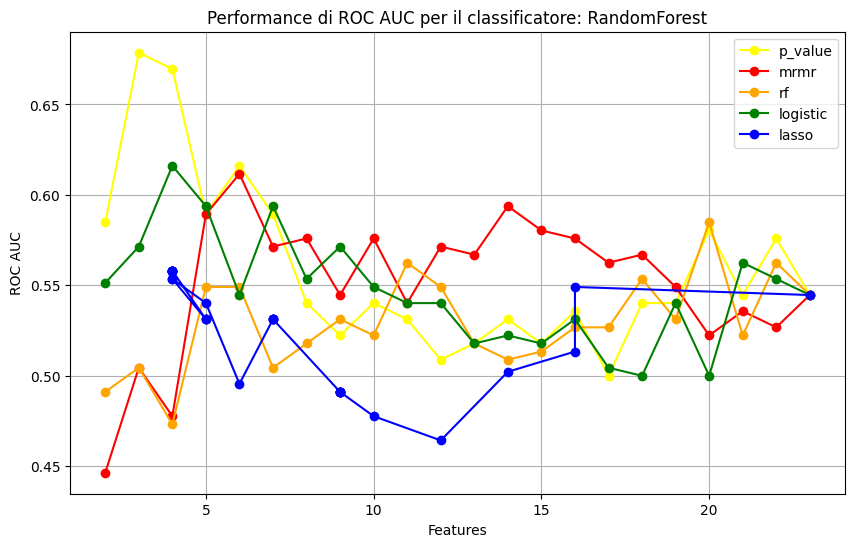

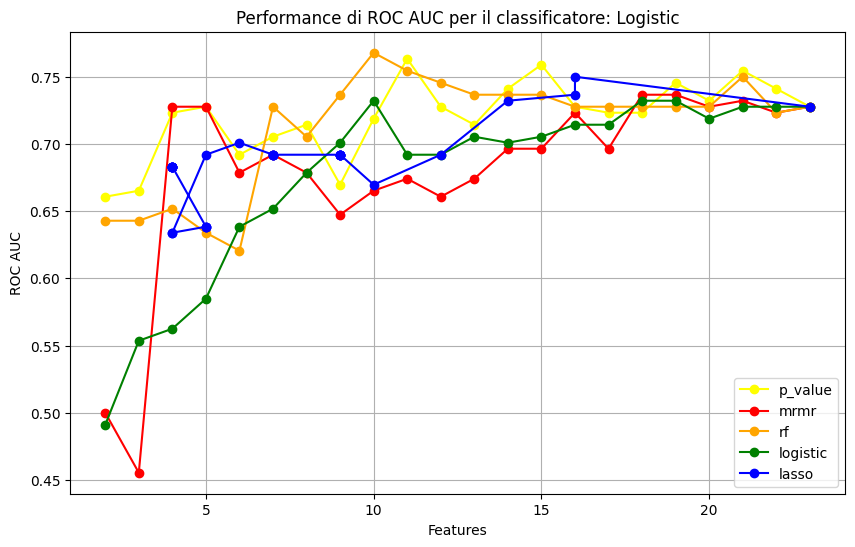

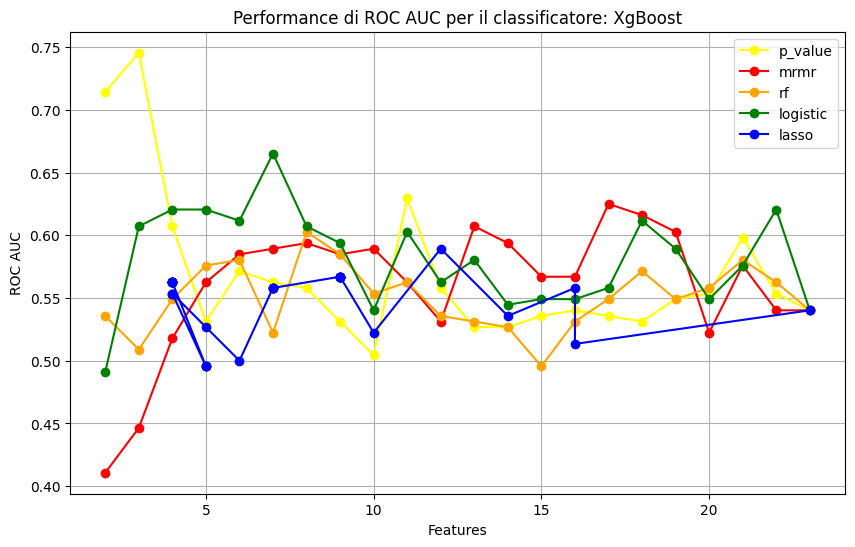

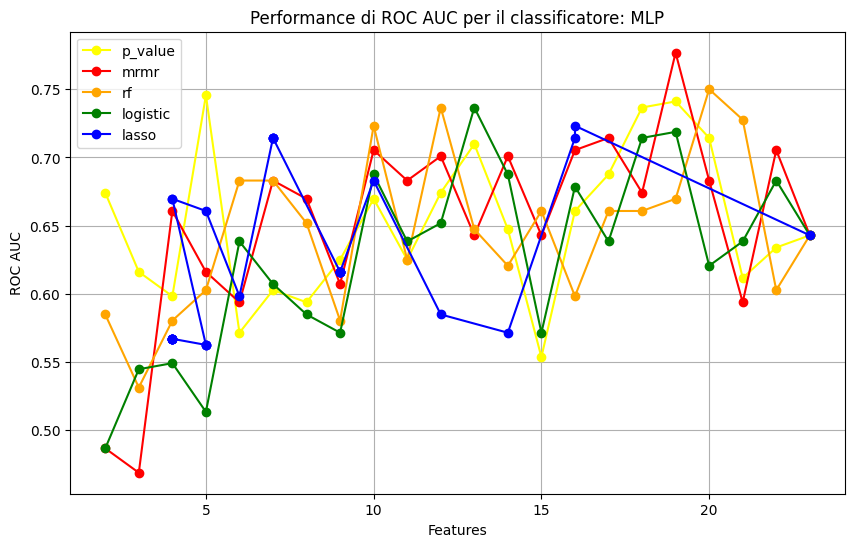

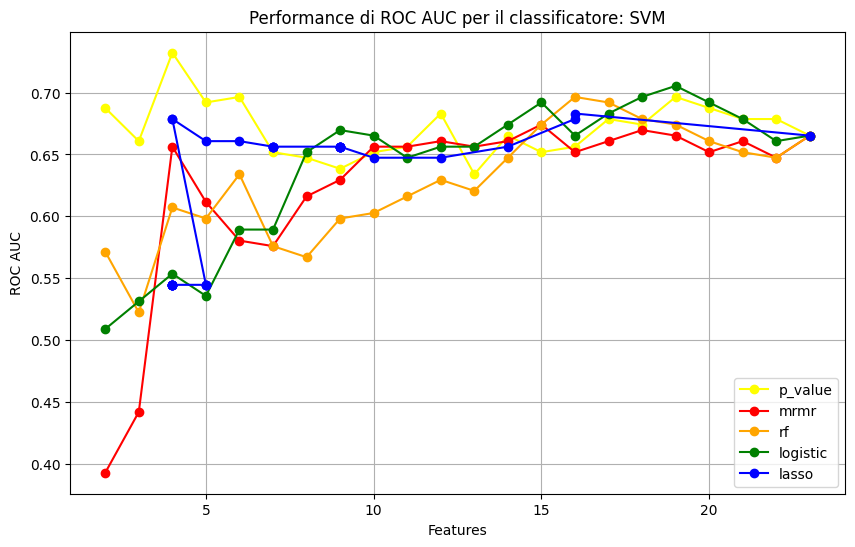

In [240]:
import matplotlib.pyplot as plt

# Definizione di colori diversi per ogni selettore
colors = {
    'lasso': 'blue',
    'logistic': 'green',  # sostituire con il nome effettivo del selettore
    'mrmr': 'red',    # sostituire con il nome effettivo del selettore
    'rf': 'orange',
    'p_value': 'yellow'
    # aggiungere altri selettori se necessario
}

# Itera attraverso i classificatori e crea i grafici
for i, classifier in enumerate(classifiers):
    plt.figure(figsize=(10, 6))
    for selector in selectors:
        num_features = results_val_MV[i][selector]['num_features']
        roc_auc = results_val_MV[i][selector]['roc_auc']  # Utilizzo di roc_auc anziché pr_auc

        plt.plot(num_features, roc_auc, marker='o', label=selector, color=colors.get(selector, 'black'))

    plt.title(f'Performance di ROC AUC per il classificatore: {classifier}')
    plt.xlabel('Features')
    plt.ylabel('ROC AUC')
    plt.legend()
    plt.grid(True)
    plt.show()


### PR

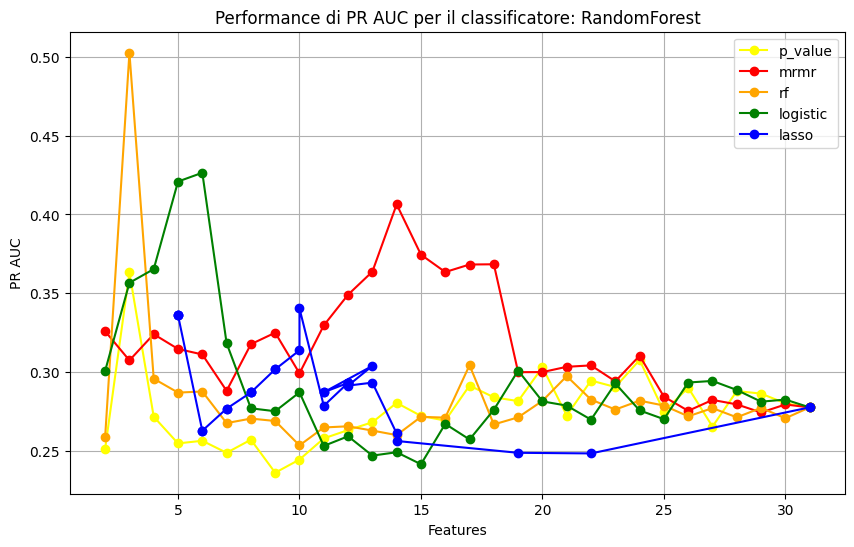

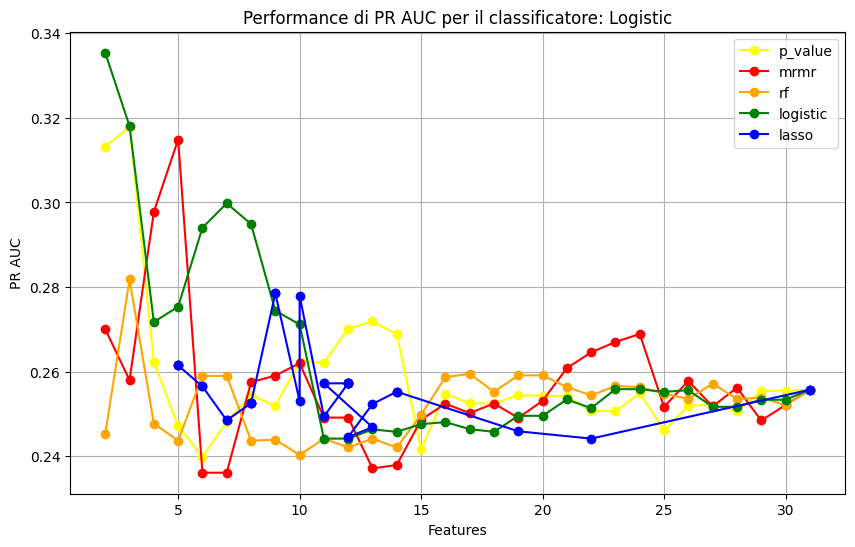

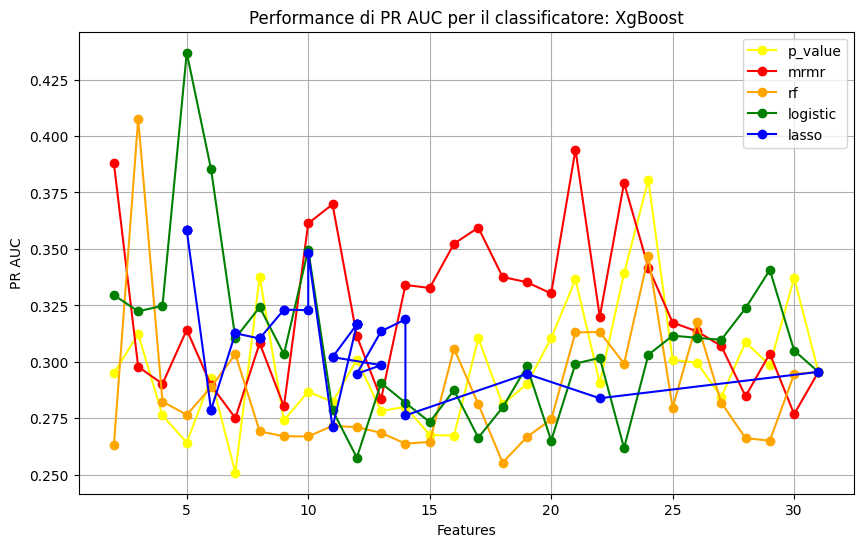

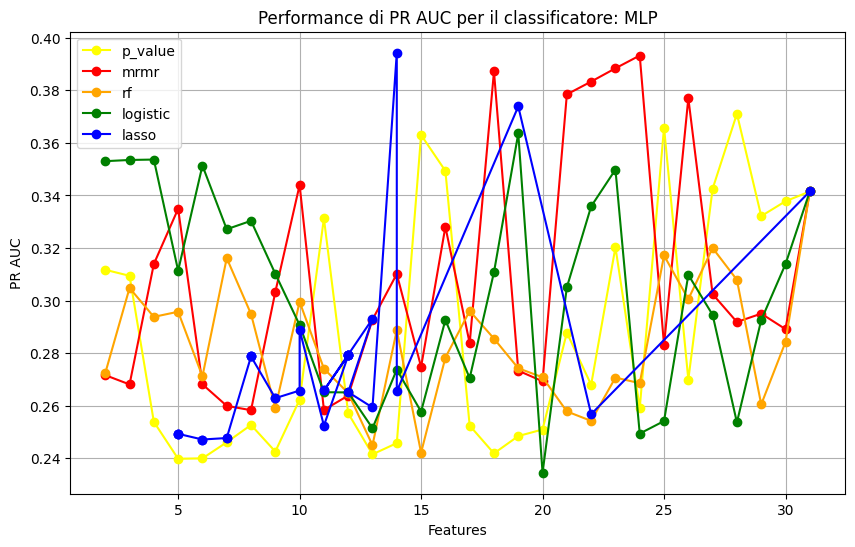

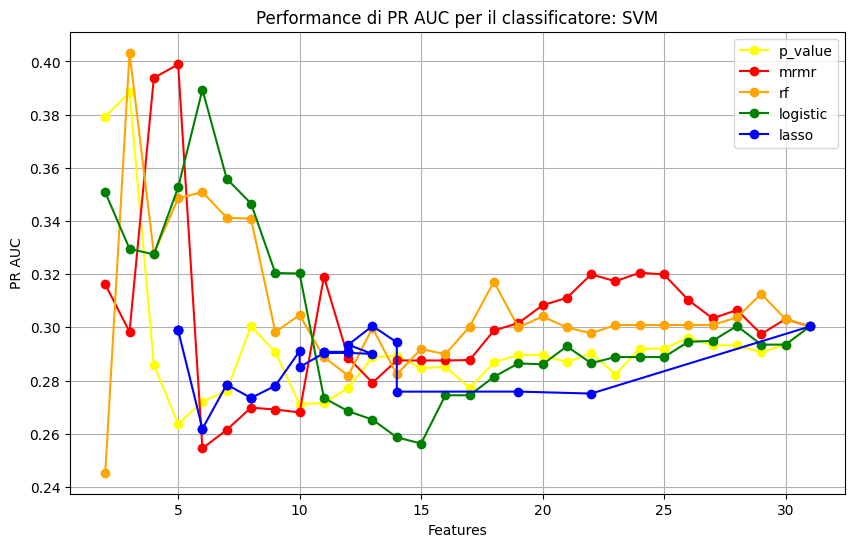

In [220]:
import matplotlib.pyplot as plt

# Definizione di colori diversi per ogni selettore
colors = {
    'lasso': 'blue',
    'logistic': 'green',  # sostituire con il nome effettivo del selettore
    'mrmr': 'red',    # sostituire con il nome effettivo del selettore
    'rf': 'orange',
    'p_value':'yellow'
    # aggiungere altri selettori se necessario
}

# Itera attraverso i classificatori e crea i grafici
for i, classifier in enumerate(classifiers):
    plt.figure(figsize=(10, 6))
    for selector in selectors:
        num_features = results_val[i][selector]['num_features']
        pr_auc = results_val[i][selector]['pr_auc']

        plt.plot(num_features, pr_auc, marker='o', label=selector, color=colors.get(selector, 'black'))

    plt.title(f'Performance di PR AUC per il classificatore: {classifier}')
    plt.xlabel('Features')
    plt.ylabel('PR AUC')
    plt.legend()
    plt.grid(True)
    plt.show()

## Selezione dei migliori casi per ogni classifier rispetto a tutti i selector

In [249]:
# Dizionario per memorizzare i migliori risultati per ogni classificatore
best_results_per_classifier = {classifier: {'selector': None, 'result': None} for classifier in classifiers}

results_val=results_val_Mean
# Funzione per confrontare i risultati e determinare se è migliore
def is_better(result, best_result):
    if 'result' not in best_result or best_result['result'] is None:
        return True
    
    if result['f1'] > best_result['result']['f1']:
        return True
    elif result['f1'] == best_result['result']['f1']:
        if result['pr_auc'] > best_result['result']['pr_auc']:
            return True
        elif result['pr_auc'] == best_result['result']['pr_auc']:
            if result['roc_auc'] > best_result['result']['roc_auc']:
                return True
            elif result['roc_auc'] == best_result['result']['roc_auc']:
                if result['accuracy'] > best_result['result']['accuracy']:
                    return True
                elif result['accuracy'] == best_result['result']['accuracy']:
                    if result['num_features'] > best_result['result']['num_features']:
                        return True
    return False

# Iterazione attraverso i classificatori e i selettori
for i, classifier in enumerate(classifiers):
    for selector in selectors:
        num_results = len(results_val[i][selector]['f1'])
           
        for j in range(num_results):
            current_result = {
                'classifier': classifier,
                'selector': selector,
                'f1': results_val[i][selector]['f1'][j],
                'pr_auc': results_val[i][selector]['pr_auc'][j],
                'roc_auc': results_val[i][selector]['roc_auc'][j],
                'accuracy': results_val[i][selector]['accuracy'][j],
                'num_features': results_val[i][selector]['num_features'][j],
                'confusion_matrix': results_val[i][selector]['confusion_matrix'][j],
                'best_precision': results_val[i][selector]['best_precision'][j],
                'best_recall': results_val[i][selector]['best_recall'][j],
                'roc_auc': results_val[i][selector]['roc_auc'][j],
                'f1': results_val[i][selector]['f1'][j],
                'accuracy': results_val[i][selector]['accuracy'][j],
                'confusion_matrix': results_val[i][selector]['confusion_matrix'][j],
                'best_threshold': results_val[i][selector]['best_threshold'][j],
                'selected_features': results_val[i][selector]['selected_features'][j]
            }
            
            if is_better(current_result, best_results_per_classifier[classifier]):
                best_results_per_classifier[classifier] = {
                    'selector': selector,
                    'result': current_result
                }

classifier_alphas = {}

# Stampare il miglior risultato per ogni classificatore
for classifier, best_result_info in best_results_per_classifier.items():
    best_result = best_result_info['result']
    best_selector = best_result_info['selector']
    
    print(f"Miglior risultato per il classificatore {classifier} (selector {best_selector}):")
    print(f"F1 score: {best_result['f1']}")
    print(f"PR AUC: {best_result['pr_auc']}")
    print(f"ROC AUC: {best_result['roc_auc']}")
    print(f"Accuracy: {best_result['accuracy']}")
    print(f"Numero di features: {best_result['num_features']}")
    print(f"Confusion Matrix:")
    print(best_result['confusion_matrix'])
    print(f"Best Precision: {best_result['best_precision']}")
    print(f"Best Recall: {best_result['best_recall']}")
    print(f"Best Threshold: {best_result['best_threshold']}")
    print(f"Selected Features: {best_result['selected_features']}")


        # Se il selettore è "lasso", recupera e stampa anche il valore di alpha
    if best_selector == 'lasso':
        # Trova l'indice del miglior risultato in results_val per il classificatore e selettore correnti
        idx = results_val[classifiers.index(classifier)][best_selector]['f1'].index(best_result['f1'])
        alpha_opt = results_val[classifiers.index(classifier)][best_selector]['alpha'][idx]
        print(f"Alpha: {alpha_opt}")
    else:
        alpha_opt = 0

    classifier_alphas[classifier] = alpha_opt
    
    print("--------------------")

    print("--------------------")


Miglior risultato per il classificatore RandomForest (selector p_value):
F1 score: 0.7428571428571429
PR AUC: 0.5763014909067541
ROC AUC: 0.6785714285714286
Accuracy: 0.7
Numero di features: 3
Confusion Matrix:
[[ 8  8]
 [ 1 13]]
Best Precision: 0.6190476190476191
Best Recall: 0.9285714285714286
Best Threshold: 0.436
Selected Features: [0 1 2]
--------------------
--------------------
Miglior risultato per il classificatore Logistic (selector p_value):
F1 score: 0.7741935483870968
PR AUC: 0.6501417949624991
ROC AUC: 0.7276785714285714
Accuracy: 0.7666666666666667
Numero di features: 12
Confusion Matrix:
[[11  5]
 [ 2 12]]
Best Precision: 0.7058823529411765
Best Recall: 0.8571428571428571
Best Threshold: 0.492
Selected Features: [ 0  1  2  3  4  5  6  7  8  9 10 11]
--------------------
--------------------
Miglior risultato per il classificatore XgBoost (selector p_value):
F1 score: 0.75
PR AUC: 0.650127947449376
ROC AUC: 0.7455357142857142
Accuracy: 0.7333333333333333
Numero di featur

## Estrazione migliore dei migliori

In [247]:
best_overall_result = None
best_overall_classifier = None
best_overall_selector = None

for classifier, best_result_info in best_results_per_classifier.items():
    if 'result' in best_result_info and best_result_info['result'] is not None:
        best_result = best_result_info['result']
        selector = best_result_info['selector']
        
        # Se non abbiamo ancora un miglior risultato globale, lo impostiamo direttamente
        if best_overall_result is None:
            best_overall_result = best_result
            best_overall_classifier = classifier
            best_overall_selector = selector
        else:
            # Altrimenti, confrontiamo i risultati per trovare il miglior classificatore globale
            if (best_result['f1'] > best_overall_result['f1'] or
                (best_result['f1'] == best_overall_result['f1'] and
                 best_result['pr_auc'] > best_overall_result['pr_auc']) or
                (best_result['f1'] == best_overall_result['f1'] and
                 best_result['pr_auc'] == best_overall_result['pr_auc'] and
                 best_result['roc_auc'] > best_overall_result['roc_auc']) or
                (best_result['f1'] == best_overall_result['f1'] and
                 best_result['pr_auc'] == best_overall_result['pr_auc'] and
                 best_result['roc_auc'] == best_overall_result['roc_auc'] and
                 best_result['accuracy'] > best_overall_result['accuracy']) or
                (best_result['f1'] == best_overall_result['f1'] and
                 best_result['pr_auc'] == best_overall_result['pr_auc'] and
                 best_result['roc_auc'] == best_overall_result['roc_auc'] and
                 best_result['accuracy'] == best_overall_result['accuracy'] and
                 best_result['num_features'] > best_overall_result['num_features'])):
                
                best_overall_result = best_result
                best_overall_classifier = classifier
                best_overall_selector = selector

# Salvare i dati desiderati per il migliore dei migliori
if best_overall_result is not None:
    best_threshold_fin = best_overall_result['best_threshold']
    selected_features_fin = best_overall_result['selected_features']
    alpha_fin = classifier_alphas[best_overall_classifier]

    print(f"Miglior classificatore globale: {best_overall_classifier} (selector {best_overall_selector})")
    print(f"Threshold: {best_threshold_fin}")
    print(f"Selected Features: {selected_features_fin}")
    print(f"Alpha: {alpha_fin}")

else:
    print("Nessun miglior risultato globale trovato.")


Miglior classificatore globale: MLP (selector p_value)
Threshold: 0.486
Selected Features: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Alpha: 0


## mean e MV trova il migliore per val

In [326]:
# Dizionario per memorizzare i migliori risultati per ogni classificatore
best_results_per_classifier = {
    classifier: {
        'selector': None,
        'result': None,
        'mode': None
    } for classifier in classifiers
}

# Funzione per confrontare i risultati e determinare se è migliore
def is_better(result, best_result):
    if 'result' not in best_result or best_result['result'] is None:
        return True
    
    if result['f1'] > best_result['result']['f1']:
        return True
    elif result['f1'] == best_result['result']['f1']:
        if result['pr_auc'] > best_result['result']['pr_auc']:
            return True
        elif result['pr_auc'] == best_result['result']['pr_auc']:
            if result['roc_auc'] > best_result['result']['roc_auc']:
                return True
    return False

# Funzione per trovare i migliori risultati per un dato set di risultati
def find_best_results(results_val, mode):
    for i, classifier in enumerate(classifiers):
        for selector in selectors:
            num_results = len(results_val[i][selector]['f1'])

            for j in range(num_results):
                current_result = {
                    'classifier': classifier,
                    'selector': selector,
                    'f1': results_val[i][selector]['f1'][j],
                    'pr_auc': results_val[i][selector]['pr_auc'][j],
                    'roc_auc': results_val[i][selector]['roc_auc'][j],
                    'accuracy': results_val[i][selector]['accuracy'][j],
                    'num_features': results_val[i][selector]['num_features'][j],
                    'confusion_matrix': results_val[i][selector]['confusion_matrix'][j],
                    'best_precision': results_val[i][selector]['best_precision'][j],
                    'best_recall': results_val[i][selector]['best_recall'][j],
                    'best_threshold': results_val[i][selector]['best_threshold'][j],
                    'selected_features': results_val[i][selector]['selected_features'][j]
                }

                if is_better(current_result, best_results_per_classifier[classifier]):
                    best_results_per_classifier[classifier] = {
                        'selector': selector,
                        'result': current_result,
                        'mode': mode
                    }

# Trova i migliori risultati per entrambi i set di risultati
find_best_results(results_val_Mean, 'mean')
find_best_results(results_val_MV, 'majority voting')

classifier_alphas = {}

# Stampa i migliori risultati per ogni classificatore
for classifier, best_result_info in best_results_per_classifier.items():
    best_result = best_result_info['result']
    best_selector = best_result_info['selector']
    mode = best_result_info['mode']
    
    print(f"Miglior risultato per il classificatore {classifier}")
    print(f"Selector {best_selector} and mode {mode}:")
    print(f"F1 score: {best_result['f1']}")
    print(f"PR AUC: {best_result['pr_auc']}")
    print(f"ROC AUC: {best_result['roc_auc']}")
    print(f"Accuracy: {best_result['accuracy']}")
    print(f"Numero di features: {best_result['num_features']}")
    print(f"Confusion Matrix:")
    print(best_result['confusion_matrix'])
    print(f"Best Precision: {best_result['best_precision']}")
    print(f"Best Recall: {best_result['best_recall']}")
    print(f"Best Threshold: {best_result['best_threshold']}")
    print(f"Selected Features: {best_result['selected_features']}")

    # Se il selettore è "lasso", recupera e stampa anche il valore di alpha
    if best_selector == 'lasso':
        # Trova l'indice del miglior risultato in results_val per il classificatore e selettore correnti
        if mode == 'mean':
            idx = results_val_Mean[classifiers.index(classifier)][best_selector]['f1'].index(best_result['f1'])
            alpha_opt = results_val_Mean[classifiers.index(classifier)][best_selector]['alpha'][idx]
        else:
            idx = results_val_MV[classifiers.index(classifier)][best_selector]['f1'].index(best_result['f1'])
            alpha_opt = results_val_MV[classifiers.index(classifier)][best_selector]['alpha'][idx]
        print(f"Alpha: {alpha_opt}")
    else:
        alpha_opt = 0

    classifier_alphas[classifier] = alpha_opt
    
    print("--------------------")

print("--------------------")

# Trova il miglior classificatore globale
best_overall_result = None
best_overall_classifier = None
best_overall_selector = None
best_overall_mode = None

for classifier, best_result_info in best_results_per_classifier.items():
    if 'result' in best_result_info and best_result_info['result'] is not None:
        best_result = best_result_info['result']
        selector = best_result_info['selector']
        mode = best_result_info['mode']
        
        # Se non abbiamo ancora un miglior risultato globale, lo impostiamo direttamente
        if best_overall_result is None:
            best_overall_result = best_result
            best_overall_classifier = classifier
            best_overall_selector = selector
            best_overall_mode = mode
        else:
            # Confrontiamo i risultati per trovare il miglior classificatore globale
            if (best_result['f1'] > best_overall_result['f1'] or
                (best_result['f1'] == best_overall_result['f1'] and
                 best_result['pr_auc'] > best_overall_result['pr_auc']) or
                (best_result['f1'] == best_overall_result['f1'] and
                 best_result['pr_auc'] == best_overall_result['pr_auc'] and
       
                 best_result['roc_auc'] > best_overall_result['roc_auc'])):
                
                best_overall_result = best_result
                best_overall_classifier = classifier
                best_overall_selector = selector
                best_overall_mode = mode

# Stampa il miglior risultato globale
if best_overall_result is not None:
    best_threshold_fin = best_overall_result['best_threshold']
    selected_features_fin = best_overall_result['selected_features']
    alpha_fin = classifier_alphas[best_overall_classifier]

    print(f"Miglior classificatore globale: {best_overall_classifier} (selector {best_overall_selector}, mode {best_overall_mode})")
    print(f"Threshold: {best_threshold_fin}")
    print(f"Selected Features: {selected_features_fin}")
    print(f"Alpha: {alpha_fin}")
else:
    print("Nessun miglior risultato globale trovato.")


Miglior risultato per il classificatore RandomForest
Selector mrmr and mode mean:
F1 score: 0.5641025641025641
PR AUC: 0.48972912609276253
ROC AUC: 0.49282296650717705
Accuracy: 0.43333333333333335
Numero di features: 10
Confusion Matrix:
[[ 2 17]
 [ 0 11]]
Best Precision: 0.39285714285714285
Best Recall: 1.0
Best Threshold: 0.363
Selected Features: [0, 1, 6, 11, 5, 13, 19, 3, 17, 7]
--------------------
Miglior risultato per il classificatore Logistic
Selector rf and mode mean:
F1 score: 0.6060606060606061
PR AUC: 0.511879800938343
ROC AUC: 0.5645933014354068
Accuracy: 0.5666666666666667
Numero di features: 2
Confusion Matrix:
[[ 7 12]
 [ 1 10]]
Best Precision: 0.45454545454545453
Best Recall: 0.9090909090909091
Best Threshold: 0.482
Selected Features: [15  6]
--------------------
Miglior risultato per il classificatore XgBoost
Selector lasso and mode mean:
F1 score: 0.6111111111111112
PR AUC: 0.4575078544643762
ROC AUC: 0.5645933014354068
Accuracy: 0.5333333333333333
Numero di featur

## Stampa miglior classifier con test

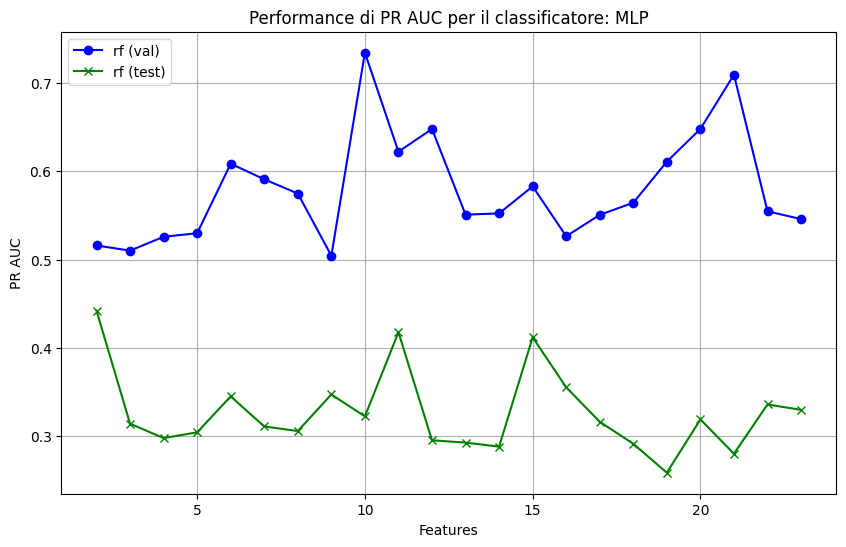

Risultati per 21 funzionalità:
PR AUC: 0.28004908103592313
ROC AUC: 0.38235294117647056
F1: 0.5161290322580645
Precision: 0.34782608695652173
Recall: 1.0
Accuracy: 0.4
Confusion Matrix:
[[ 2 15]
 [ 0  8]]



In [278]:
import matplotlib.pyplot as plt

# Dati da utilizzare per il grafico
classifier = best_overall_classifier
selector = best_overall_selector


# Recupera i dati di PR AUC e numero di features per results_val e results_test
num_features_val = results_val[classifiers.index(classifier)][selector]['num_features']
pr_auc_val = results_val[classifiers.index(classifier)][selector]['pr_auc']

num_features_test = results_test[classifiers.index(classifier)][selector]['num_features']
pr_auc_test = results_test[classifiers.index(classifier)][selector]['pr_auc']



# Definizione di colori diversi per validazione e test
color_val = 'blue'
color_test = 'green'

plt.figure(figsize=(10, 6))

# Plot per results_val (validazione)
plt.plot(num_features_val, pr_auc_val, marker='o', label=f'{selector} (val)', color=color_val)

# Plot per results_test (test)
plt.plot(num_features_test, pr_auc_test, marker='x', label=f'{selector} (test)', color=color_test)

plt.title(f'Performance di PR AUC per il classificatore: {classifier}')
plt.xlabel('Features')
plt.ylabel('PR AUC')
plt.legend()
plt.grid(True)
plt.show()



specific_num_features = len(selected_features_fin)  # Adatta questo valore al tuo numero specifico di funzionalità

# Cerca l'indice del numero di funzionalità specificato
if specific_num_features in num_features_test:
    index = num_features_test.index(specific_num_features)
    
    # Stampa i risultati per il numero di funzionalità specificato
    print(f"Risultati per {specific_num_features} funzionalità:")
    print(f"PR AUC: {results_test[classifiers.index(classifier)][selector]['pr_auc'][index]}")
    print(f"ROC AUC: {results_test[classifiers.index(classifier)][selector]['roc_auc'][index]}")
    print(f"F1: {results_test[classifiers.index(classifier)][selector]['f1'][index]}")
    print(f"Precision: {results_test[classifiers.index(classifier)][selector]['best_precision'][index]}")
    print(f"Recall: {results_test[classifiers.index(classifier)][selector]['best_recall'][index]}")
    print(f"Accuracy: {results_test[classifiers.index(classifier)][selector]['accuracy'][index]}")
    print(f"Confusion Matrix:\n{results_test[classifiers.index(classifier)][selector]['confusion_matrix'][index]}\n")
else:
    print(f"Numero di funzionalità {specific_num_features} non trovato nei risultati di test.")



## codice per MV e Mean

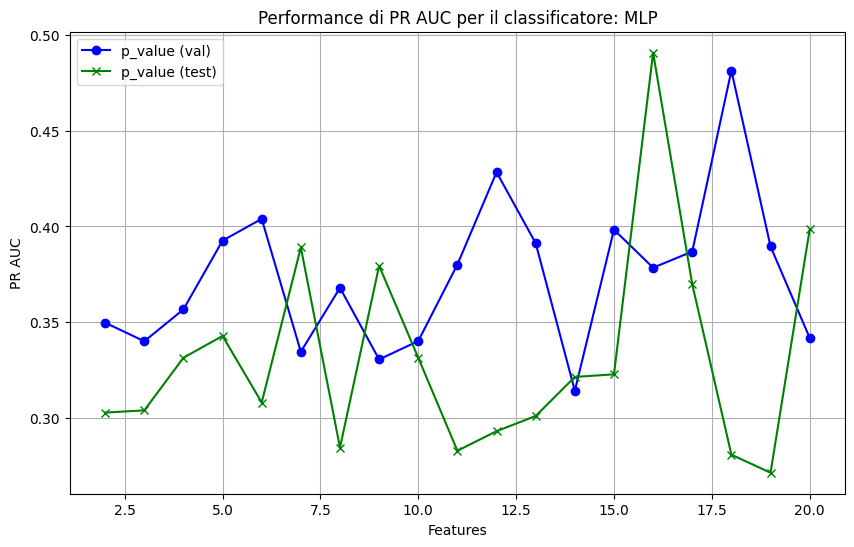

Risultati per 15 funzionalità:
PR AUC: 0.3227621610845295
ROC AUC: 0.4485294117647059
F1: 0.38095238095238093
Precision: 0.3076923076923077
Recall: 0.5
Accuracy: 0.48
Confusion Matrix:
[[8 9]
 [4 4]]



In [327]:
import matplotlib.pyplot as plt

# Dati da utilizzare per il grafico
classifier = best_overall_classifier
selector = best_overall_selector
mode = best_overall_mode

# Seleziona il set di risultati di test corretto in base alla modalità
if mode == 'mean':
    results_test = results_test_Mean
else:
    results_test = results_test_MV

# Recupera i dati di PR AUC e numero di features per results_val e results_test
num_features_val = results_val_Mean[classifiers.index(classifier)][selector]['num_features'] if mode == 'mean' else results_val_MV[classifiers.index(classifier)][selector]['num_features']
pr_auc_val = results_val_Mean[classifiers.index(classifier)][selector]['pr_auc'] if mode == 'mean' else results_val_MV[classifiers.index(classifier)][selector]['pr_auc']

num_features_test = results_test[classifiers.index(classifier)][selector]['num_features']
pr_auc_test = results_test[classifiers.index(classifier)][selector]['pr_auc']

# Definizione di colori diversi per validazione e test
color_val = 'blue'
color_test = 'green'

plt.figure(figsize=(10, 6))

# Plot per results_val (validazione)
plt.plot(num_features_val, pr_auc_val, marker='o', label=f'{selector} (val)', color=color_val)

# Plot per results_test (test)
plt.plot(num_features_test, pr_auc_test, marker='x', label=f'{selector} (test)', color=color_test)

plt.title(f'Performance di PR AUC per il classificatore: {classifier}')
plt.xlabel('Features')
plt.ylabel('PR AUC')
plt.legend()
plt.grid(True)
plt.show()

specific_num_features = len(selected_features_fin)  # Adatta questo valore al tuo numero specifico di funzionalità

# Cerca l'indice del numero di funzionalità specificato
if specific_num_features in num_features_test:
    index = num_features_test.index(specific_num_features)
    
    # Stampa i risultati per il numero di funzionalità specificato
    print(f"Risultati per {specific_num_features} funzionalità:")
    print(f"PR AUC: {results_test[classifiers.index(classifier)][selector]['pr_auc'][index]}")
    print(f"ROC AUC: {results_test[classifiers.index(classifier)][selector]['roc_auc'][index]}")
    print(f"F1: {results_test[classifiers.index(classifier)][selector]['f1'][index]}")
    print(f"Precision: {results_test[classifiers.index(classifier)][selector]['best_precision'][index]}")
    print(f"Recall: {results_test[classifiers.index(classifier)][selector]['best_recall'][index]}")
    print(f"Accuracy: {results_test[classifiers.index(classifier)][selector]['accuracy'][index]}")
    print(f"Confusion Matrix:\n{results_test[classifiers.index(classifier)][selector]['confusion_matrix'][index]}\n")
else:
    print(f"Numero di funzionalità {specific_num_features} non trovato nei risultati di test.")


## Test con training intero

In [328]:
#patients_train, patients_test, y_train, y_test, features_train, features_test= train_test_split(loaded_patients, labels, patients, test_size=0.2, shuffle=False, random_state=1)

if(best_overall_classifier=='RandomForest'):
         classi = RandomForestClassifier(n_estimators=100, random_state=42)
if(best_overall_classifier=='Logistic'):
                             classi = LogisticRegression()
if(best_overall_classifier=='SVM'):
                             classi = SVC(kernel='rbf', probability=True, random_state=42)
if(best_overall_classifier=='XgBoost'):
                             classi = XGBClassifier()
if(best_overall_classifier=='MLP'):
                             classi = MLPClassifier(hidden_layer_sizes=(128,64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')

#x_train_expanded, y_train_expanded, _= continue_array(features_train1, y_train1)

sf = stringhe_numeri = [str(f) for f in selected_features_fin]

final_patients_train = keep_features_in_patients(features_train1, sf)

x_train_expanded, y_train_expanded, _ = continue_array(final_patients_train, y_train1)

features_test_fin = keep_features_in_patients(features_test, sf)
print(best_overall_mode)
if(best_overall_mode=='majority voting'):
    best_overall_mode='MV'
if(best_overall_mode=='M'):
    best_overall_mode='Mean'

    
f1_final, precision_final, recall_final, conf_final, accuracy_final= classification_method2(classi, x_train_expanded, y_train_expanded, patients_test, y_test, features_test_fin, best_threshold_fin, best_overall_mode)

print(f"classifier: {best_overall_classifier}")
print(f"selector: {best_overall_selector}")
print(f"F1 score finale: {f1_final}")
print(f"Precision finale: {precision_final}")
print(f"Recall finale: {recall_final}")
print("Confusion Matrix finale:")
print(conf_final)
print(f"Accuracy finale: {accuracy_final}")
print(f"threshold: {best_threshold_fin}")
print(f"features: {selected_features_fin} e sono {len(selected_features_fin)}")





majority voting
[[array([[0.30019373, 0.6998063 ]], dtype=float32), array([[0.34641945, 0.65358055]], dtype=float32), array([[0.42095232, 0.5790477 ]], dtype=float32), array([[0.43960398, 0.560396  ]], dtype=float32), array([[0.49851215, 0.50148785]], dtype=float32), array([[0.4541433, 0.5458567]], dtype=float32), array([[0.3622179, 0.6377821]], dtype=float32), array([[0.625059, 0.374941]], dtype=float32), array([[0.5259054, 0.4740946]], dtype=float32), array([[0.50381154, 0.49618846]], dtype=float32), array([[0.4415804, 0.5584196]], dtype=float32), array([[0.554838, 0.445162]], dtype=float32), array([[0.3605314, 0.6394686]], dtype=float32), array([[0.40415412, 0.5958459 ]], dtype=float32), array([[0.3798297, 0.6201703]], dtype=float32), array([[0.13265282, 0.8673472 ]], dtype=float32), array([[0.21135616, 0.78864384]], dtype=float32), array([[0.30582517, 0.6941748 ]], dtype=float32)], [array([[0.6269988 , 0.37300122]], dtype=float32), array([[0.5591862 , 0.44081375]], dtype=float32), 